# Download Data

In [ ]:
!wget https://raw.githubusercontent.com/mmalekzadeh/motion-sense/master/data/data_subjects_info.csv
!wget -O A_DeviceMotion_data.zip https://github.com/mmalekzadeh/motion-sense/blob/master/data/A_DeviceMotion_data.zip?raw=true

In [ ]:
!unzip A_DeviceMotion_data.zip

# Process Data
Use script provided by [data source ](https://github.com/mmalekzadeh/motion-sense/blob/master/codes/0_import_dataset_and_creat_labeld_time_series.ipynb)

In [ ]:
!pip install cloudmesh-installer
from cloudmesh.common.StopWatch import StopWatch


In [26]:
import numpy as np
import pandas as pd
##_____________________________

def get_ds_infos():
    ## 0:Code, 1:Weight, 2:Height, 3:Age, 4:Gender
    dss = np.genfromtxt("data_subjects_info.csv",delimiter=',')
    dss = dss[1:]
    print("----> Data subjects information is imported.")
    return dss
##____________

def creat_time_series(num_features, num_act_labels, num_gen_labels, label_codes, trial_codes):
    dataset_columns = num_features+num_act_labels+num_gen_labels
    ds_list = get_ds_infos()
    train_data = np.zeros((0,dataset_columns))
    test_data = np.zeros((0,dataset_columns))
    for i, sub_id in enumerate(ds_list[:,0]):
        for j, act in enumerate(label_codes):
            for trial in trial_codes[act]:
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                unlabel_data = raw_data.values
                label_data = np.zeros((len(unlabel_data), dataset_columns))
                label_data[:,:-(num_act_labels + num_gen_labels)] = unlabel_data
                label_data[:,label_codes[act]] = 1
                label_data[:,-(num_gen_labels)] = int(ds_list[i,4])
                ## We consider long trials as training dataset and short trials as test dataset
                if trial > 10:
                    test_data = np.append(test_data, label_data, axis = 0)
                else:    
                    train_data = np.append(train_data, label_data, axis = 0)
    return train_data , test_data
#________________________________


print("--> Start...")
## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
num_features = 12 # attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
num_act_labels = 6 # dws, ups, wlk, jog, sit, stand
num_gen_labels = 1 # 0/1(female/male)
# label_codes = {"dws":num_features, "ups":num_features+1, "wlk":num_features+2, "jog":num_features+3}
# trial_codes = {"dws":[1,2,11], "ups":[3,4,12], "wlk":[7,8,15], "jog":[9,16]}  
label_codes = {"dws":num_features, "ups":num_features+1, "wlk":num_features+2, "jog":num_features+3, "sit":num_features+4, "std":num_features+5}
trial_codes = {"dws":[1,2,11], "ups":[3,4,12], "wlk":[7,8,15], "jog":[9,16], "sit":[5,13], "std":[6,14]}      
## Calling 'creat_time_series()' to build time-series
print("--> Building Training and Test Datasets...")
train_ts, test_ts = creat_time_series(num_features, num_act_labels, num_gen_labels, label_codes, trial_codes)
print("--> Shape of Training Time-Seires:", train_ts.shape)
print("--> Shape of Test Time-Series:", test_ts.shape)

--> Start...
--> Building Training and Test Datasets...
----> Data subjects information is imported.
--> Shape of Training Time-Seires: (1081446, 19)
--> Shape of Test Time-Series: (331419, 19)


In [28]:
def time_series_to_section(dataset, num_act_labels, num_gen_labels, sliding_window_size, step_size_of_sliding_window, standardize = False, **options):
    data = dataset[: , 0:-(num_act_labels+num_gen_labels)]
    act_labels = dataset[: , -(num_act_labels+num_gen_labels):-(num_gen_labels)]
    gen_labels = dataset[: , -(num_gen_labels)]
    mean = 0
    std = 1
    
    if standardize:
        ## Standardize each sensor’s data to have a zero mean and unity standard deviation.
        ## As usual, we normalize test dataset by training dataset's parameters 
        if options:
            mean = options.get("mean")
            std = options.get("std")
            print("----> Test Data has been standardized")
        else:
            mean = data.mean(axis=0)
            std = data.std(axis=0)
            print("----> Training Data has been standardized:\n the mean is = ",str(mean.mean())," ; and the std is = ",str(std.mean()))            
  
        data -= mean
        data /= std
    else:
        print("----> Without Standardization.....")

    ## We want the Rows of matrices show each Feature and the Columns show time points.
    data = data.T
            
    size_features = data.shape[0]
    size_data = data.shape[1]
    number_of_secs = round(((size_data - sliding_window_size)/step_size_of_sliding_window))
            
    ##  Create a 3D matrix for Storing Snapshots  
    secs_data = np.zeros((number_of_secs , size_features , sliding_window_size ))
    act_secs_labels = np.zeros((number_of_secs, num_act_labels))
    gen_secs_labels = np.zeros(number_of_secs)
    
    k=0    
    for i in range(0 ,(size_data)-sliding_window_size  , step_size_of_sliding_window):
        j = i // step_size_of_sliding_window
        if(j>=number_of_secs):
            break
        if(gen_labels[i] != gen_labels[i+sliding_window_size-1]): 
            continue
        if(not (act_labels[i] == act_labels[i+sliding_window_size-1]).all()): 
            continue    
        secs_data[k] = data[0:size_features, i:i+sliding_window_size]
        act_secs_labels[k] = act_labels[i].astype(int)
        gen_secs_labels[k] = gen_labels[i].astype(int)
        k = k+1
    secs_data = secs_data[0:k]
    act_secs_labels = act_secs_labels[0:k]
    gen_secs_labels = gen_secs_labels[0:k]
    
    return secs_data, act_secs_labels, gen_secs_labels, mean, std
##________________________________________________________________


## This Variable Defines the Size of Sliding Window
## ( e.g. 100 means in each snapshot we just consider 100 consecutive observations of each sensor) 
sliding_window_size = 50 # 50 Equals to 1 second for MotionSense Dataset (it is on 50Hz samplig rate)
## Here We Choose Step Size for Building Diffrent Snapshots from Time-Series Data
## ( smaller step size will increase the amount of the instances and higher computational cost may be incurred )
step_size_of_sliding_window = 10 
print("--> Sectioning Training and Test datasets: shape of each section will be: (",num_features,"x",sliding_window_size,")")
train_data, act_train_labels, gen_train_labels, train_mean, train_std = time_series_to_section(train_ts.copy(),
                                                                                               num_act_labels,
                                                                                               num_gen_labels,
                                                                                               sliding_window_size,
                                                                                               step_size_of_sliding_window,
                                                                                               standardize = True)

test_data, act_test_labels, gen_test_labels, test_mean, test_std = time_series_to_section(test_ts.copy(),
                                                                                          num_act_labels,
                                                                                          num_gen_labels,
                                                                                          sliding_window_size,
                                                                                          step_size_of_sliding_window,
                                                                                          standardize = True,
                                                                                          mean = train_mean, 
                                                                                          std = train_std)
print("--> Shape of Training Sections:", train_data.shape)
print("--> Shape of Test Sections:", test_data.shape)

--> Sectioning Training and Test datasets: shape of each section will be: ( 12 x 50 )
----> Training Data has been standardized:
 the mean is =  -0.043718461334099436  ; and the std is =  0.7715442524137693
----> Test Data has been standardized
--> Shape of Training Sections: (107434, 12, 50)
--> Shape of Test Sections: (32439, 12, 50)


# Descriptive Analysis

Below is the provided training data with labels added for clarity.  

In [35]:
pd.DataFrame(train_data[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1.076021,1.075932,1.075789,1.068865,1.054490,1.043383,1.030065,1.021595,1.022690,1.022457,1.016862,1.003231,0.974197,0.931256,0.883728,0.830269,0.780981,0.745238,0.715456,0.695498,0.690831,0.703395,0.733033,0.772917,0.825122,0.888924,0.962486,1.024635,1.032808,1.014063,1.010405,1.037700,1.076218,1.111977,1.122955,1.108149,1.093974,1.096349,1.100247,1.102986,1.107678,1.110640,1.112816,1.120847,1.127350,1.131719,1.135249,1.132266,1.127705,1.120185
1,0.651587,0.689113,0.711280,0.716431,0.718117,0.725022,0.739223,0.747430,0.744778,0.742261,0.741178,0.744722,0.756030,0.778516,0.814966,0.860699,0.896112,0.895127,0.885085,0.858451,0.825257,0.789730,0.735048,0.670746,0.610346,0.534816,0.439543,0.365239,0.355589,0.385130,0.441652,0.487383,0.465636,0.429499,0.433138,0.441072,0.443656,0.444632,0.456745,0.471461,0.488874,0.508681,0.525184,0.526753,0.511176,0.492887,0.480512,0.497074,0.497480,0.495155
2,0.533842,0.521767,0.517348,0.520452,0.518674,0.516370,0.511925,0.507945,0.504531,0.496097,0.482303,0.466279,0.447181,0.428280,0.414846,0.400090,0.391118,0.392178,0.393471,0.396308,0.401158,0.409262,0.425824,0.449220,0.473983,0.503652,0.547435,0.600919,0.634903,0.640400,0.633426,0.630651,0.644003,0.660474,0.667463,0.660802,0.649246,0.642549,0.639073,0.635315,0.629593,0.629615,0.629179,0.634689,0.644691,0.656598,0.670824,0.679334,0.686683,0.692745
3,2.119671,2.153390,2.172988,2.176293,2.174346,2.176904,2.184090,2.187341,2.185583,2.183314,2.179672,2.175345,2.165627,2.146658,2.121396,2.078676,2.017492,1.945600,1.874674,1.812067,1.779676,1.784364,1.808955,1.836839,1.873576,1.891073,1.868911,1.828686,1.821770,1.844549,1.899422,1.955456,1.943328,1.908938,1.911773,1.920675,1.923122,1.924190,1.936343,1.950930,1.967991,1.987210,2.003076,2.003988,1.988203,1.969791,1.957106,1.973793,1.974841,1.973405
4,-0.386333,-0.428921,-0.454371,-0.460319,-0.462265,-0.470259,-0.486770,-0.496350,-0.493250,-0.490311,-0.489049,-0.493186,-0.506418,-0.532898,-0.576284,-0.631504,-0.674849,-0.673637,-0.661297,-0.628768,-0.588634,-0.546184,-0.481906,-0.407997,-0.340275,-0.257998,-0.158161,-0.083464,-0.073968,-0.103183,-0.160322,-0.207733,-0.185055,-0.147897,-0.151610,-0.159729,-0.162378,-0.163378,-0.175853,-0.191108,-0.209295,-0.230168,-0.247705,-0.249378,-0.232810,-0.213509,-0.200543,-0.217912,-0.218339,-0.215892
5,0.226199,0.224780,0.223680,0.203159,0.160841,0.127780,0.087506,0.061802,0.065272,0.064810,0.048425,0.007964,-0.078606,-0.207453,-0.352224,-0.515798,-0.663078,-0.758920,-0.832705,-0.872628,-0.870759,-0.825769,-0.731342,-0.607878,-0.455147,-0.269572,-0.060090,0.107152,0.128440,0.078500,0.062549,0.129505,0.232808,0.326878,0.355469,0.317013,0.279966,0.286166,0.296326,0.303534,0.316076,0.324184,0.330256,0.352108,0.369310,0.380439,0.389374,0.382057,0.369846,0.349629
6,0.236574,0.634099,-0.107665,-0.022046,0.083340,0.138954,0.256520,0.130221,0.204826,0.476419,0.652018,0.761810,0.930247,0.892300,0.863537,0.944085,0.451427,-0.027116,-0.219702,-0.481748,-0.523898,-0.821000,-1.335823,-1.472956,-1.433619,-1.803007,-2.329308,-2.038407,-0.813941,0.177593,0.453121,-0.059257,-0.741032,-0.548420,-0.080713,0.413069,0.408601,0.187138,0.121415,0.193920,0.171179,-0.034996,-0.011942,-0.352032,-0.407546,-0.530981,-0.552481,-0.400694,-0.255460,-0.233716
7,0.611270,0.327506,-0.045665,-0.854258,-0.745299,-0.625584,-0.657803,-0.151567,0.345266,0.240810,0.130830,-0.544184,-1.484307,-2.251450,-2.768181,-2.936238,-2.779829,-2.243643,-1.780672,-1.100518,-0.134070,0.847106,1.360543,1.788258,2.556886,2.823060,2.551041,0.508706,-1.678729,-1.075548,0.866923,2.178973,1.614895,1.357837,-0.202743,-0.797945,-0.036159,0.574429,0.268983,0.472749,0.443768,0.085248,0.219126,0.196201,-0.156542,-0.329540,-0.466036,-0.486114,-0.728373,-0.768509
8,1.299246,0.765537,0.400960,0.027036,0.040988,0.258166,0.321856,0.052015,-0.177880,-0.156457,-0.175044,-0.037498,0.092134,0

<BarContainer object of 6 artists>

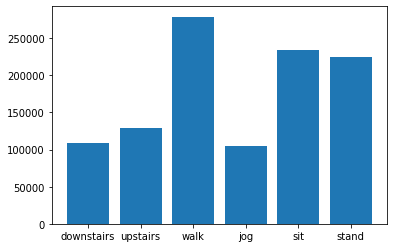

In [4]:
import matplotlib.pyplot as plt

occurences = np.sum(train_ts[:,12:18], axis=0)
x = ["downstairs", "upstairs", "walk", "jog", "sit", "stand"]

plt.bar(x, occurences)  # plot class occurences in data set



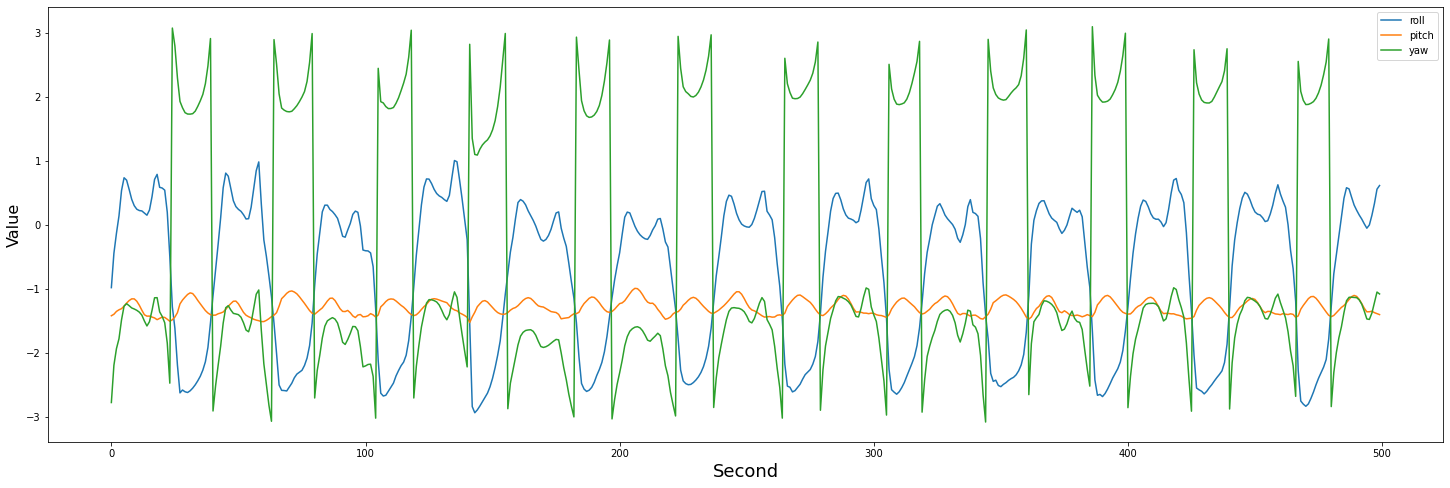

In [22]:
# plot jogging movement over time from provided code

## male
data = train_ts[train_ts[:,-1]==1]
## jogging
data = data[data[:,-4]==1]
## 10 seconds
data = pd.DataFrame(data[10000:10500,0:3])
data.plot()
plt.xlabel('Second', fontsize=18)
plt.ylabel('Value', fontsize=16)
lgnd=plt.legend()
lgnd.get_texts()[0].set_text('roll')
lgnd.get_texts()[1].set_text('pitch')
lgnd.get_texts()[2].set_text('yaw')
fig = plt.gcf()
fig.set_size_inches(25, 8)
plt.show()

[[ 1.059946 -1.331125  0.09385  ...  0.        1.        0.      ]
 [ 1.04174  -1.324215  0.074434 ...  0.        1.        0.      ]
 [ 1.026708 -1.318294  0.058913 ...  0.        1.        0.      ]
 ...
 [ 0.047078 -1.444934 -1.826624 ...  0.        1.        0.      ]
 [ 0.058243 -1.445177 -1.808854 ...  0.        1.        0.      ]
 [ 0.068046 -1.44555  -1.793355 ...  0.        1.        0.      ]]


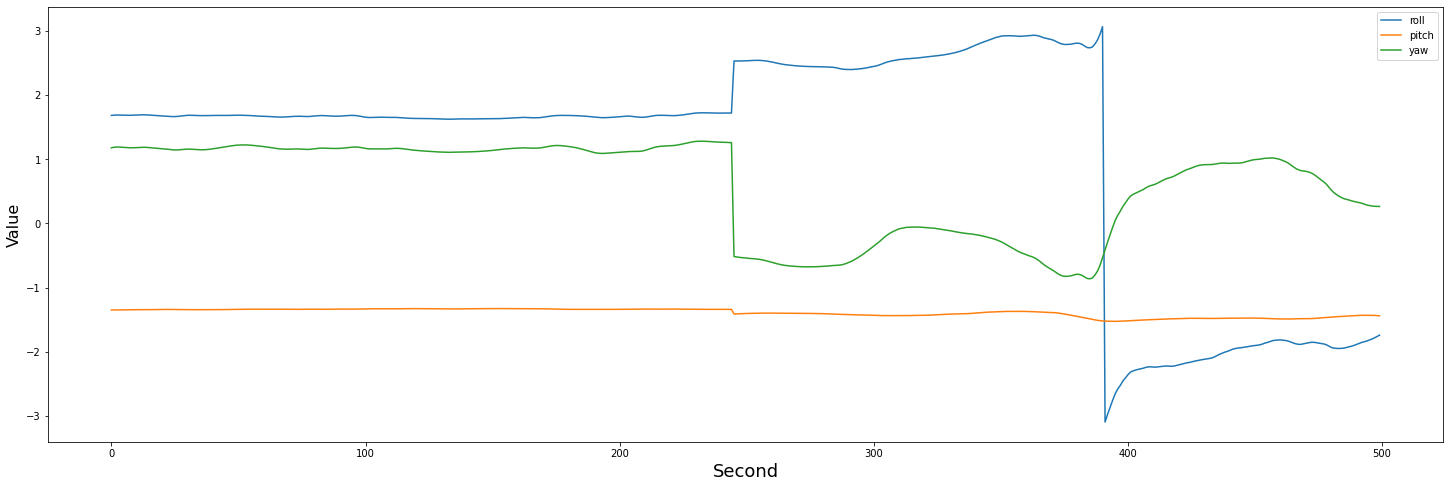

In [21]:
# plot jogging movement over time from provided code

## female
data = train_ts[train_ts[:,-1]==0]
## upstairs
data = data[data[:,-2]==1]
print(data)
## 20 seconds
data = pd.DataFrame(data[10000:10500,0:3])
data.plot()
plt.xlabel('Second', fontsize=18)
plt.ylabel('Value', fontsize=16)
lgnd=plt.legend()
lgnd.get_texts()[0].set_text('roll')
lgnd.get_texts()[1].set_text('pitch')
lgnd.get_texts()[2].set_text('yaw')
fig = plt.gcf()
fig.set_size_inches(25, 8)
plt.show()

Now we attempt classification with an LSTM 

In [48]:
from cloudmesh.common.StopWatch import StopWatch
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical


# fit and evaluate a model
def train_model(trainX, trainy, testX, testy):
  verbose, epochs, batch_size = 0, 15, 64
  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  model = Sequential()
  model.add(LSTM(50, input_shape=(n_timesteps,n_features)))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit network
  model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
  return model

def test_model(model, trainX, trainy, testX, testy):
  verbose, epochs, batch_size = 0, 15, 64
  _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  return accuracy

watch = StopWatch()
watch.start("Train LSTM")
model = train_model(train_data, act_train_labels, test_data, act_test_labels)
watch.stop("Train LSTM")
watch.status("Train LSTM", True)

watch.start("Test LSTM")
print(test_model(model, train_data, act_train_labels, test_data, act_test_labels))
watch.stop("Test LSTM")
watch.status("Test LSTM", True)

print(watch.benchmark())

0.954221785068512

+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | bionic                                                           |
| DISTRIB_DESCRIPTION | "Ubuntu 18.04.5 LTS"                                             |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 18.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                         